In [1]:
import networkx as nx
import igraph as ig
import pandas as pd
import leidenalg as la
import community as community_louvain
import matplotlib.cm as cm

#import fa2
#from fa2 import ForceAtlas2

import math
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

%matplotlib inline

In [2]:
# Erdos-Renyi adjacency matrix

def ER_adj(n,prob):
    ER = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            ER[i,j] = np.random.choice([0,1], size=1, p=[1-prob,prob])
            ER[j,i] = ER[i,j]
    return(ER)

# Erdos-Renyi adjacency matrix probabilities

def ER_prob(n,p):
    ER = np.ones((n,n))*p
    np.fill_diagonal(ER, 0)
    return(ER)

In [3]:
def triadic(A_0,n1,n2,iters, w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q):
    
    n = len(A_0)
    # A_0 = np.zeros((n,n)) #matrix of zeros
    One = np.ones((n,n))
    print("Done!")
    np.fill_diagonal(One, 0)
    print("Done!!")
    
    A = A_0
    #w = w_tilda * One # w_tilda * matrix of ones
    p = np.zeros((iters))
    c = np.zeros((iters))
    
    counter = 0
    perc = iters / 100 
    for k in range(iters):
        if counter % perc == 0:
            print(str((k/iters)*100) + "% Complete")
        counter += 1
        p[k] = (np.sum(A)/2)/((len(A)*(len(A)-1))/2)
        A_sq = np.matmul(A,A) 
        c[k] = cCoeff(A, A_sq)
        alpha_p = d_p*One + np.multiply(e_p*One,A_sq)
        alpha_r = d_r*One + np.multiply(e_r*One,A_sq)
        alpha_q = d_q*One + np.multiply(e_q*One,A_sq)
        
        for i in range(n):
            for j in range(i,n):
                if i!=j:
                    if (i < n1) and (j < n1):
                        if A[i,j] == 0:
                            A[i,j] = np.random.choice([0,1], size=1, p=[1-alpha_p[i,j],alpha_p[i,j]])
                            A[j,i] = A[i,j]
                        else:
                            A[i,j] = np.random.choice([0,1], size=1, p=[w_p,1-w_p])
                            A[j,i] = A[i,j]
                    elif (i >= n1) and (j >= n1):
                        if A[i,j] == 0:
                            A[i,j] = np.random.choice([0,1], size=1, p=[1-alpha_q[i,j],alpha_q[i,j]])
                            A[j,i] = A[i,j]
                        else:
                            A[i,j] = np.random.choice([0,1], size=1, p=[w_q,1-w_q])
                            A[j,i] = A[i,j]
                    else:
                        if A[i,j] == 0:
                            A[i,j] = np.random.choice([0,1], size=1, p=[1-alpha_r[i,j],alpha_r[i,j]])
                            A[j,i] = A[i,j]
                        else:
                            A[i,j] = np.random.choice([0,1], size=1, p=[w_r,1-w_r])
                            A[j,i] = A[i,j]
            
        #print("iteration: " + str(k))
    return(A,p,c)

In [4]:
def block(n1,p,n2,q,r): # Create Block Model
    A = ER_prob(n1,p)
    B = ER_prob(n2,q)
    n1 = len(A)
    n2 = len(B)
    Z1 = r*np.ones((n1,n2))# Create off-diagonal zeros array
    Z2 = r*np.ones((n2,n1))# Create off-diagonal zeros array
    top_half = np.concatenate((A, Z1), axis=1)
    bottom_half = np.concatenate((Z2, B), axis=1)
    block = np.concatenate((top_half, bottom_half), axis=0)
    return(block)

def block_adj(block):
    n = len(block)
    B = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            B[i,j] = np.random.choice([0,1], size=1, p=[1-block[i,j],block[i,j]])
            B[j,i] = B[i,j]
    return(B)

In [5]:
def mean_field(n1,n2,p_0,r_0,q_0,iters,w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q):


    m_field = np.zeros((iters,3))
    
    m_field[0,0] = p_0 # p
    m_field[0,1] = r_0 # r
    m_field[0,2] = q_0 # q
    
    den = np.zeros((iters))
    c_k = np.zeros((iters))
    
    den[0] = xDensity(n1,n2,p_0,q_0,r_0)
    c_k[0] = xClust(n1,n2,p_0,q_0,r_0)

    
    for i in range(0,iters-1):
        m_field[i+1,0] = (1-w_p)*m_field[i,0] + (1-m_field[i,0])*(d_p + (e_p*((n1-2)*m_field[i,0]**2  + n2*m_field[i,1]**2)))
        m_field[i+1,1] = (1-w_r)*m_field[i,1] + (1-m_field[i,1])*(d_r + (e_r*((n1-1)*m_field[i,1]*m_field[i,0]  + (n2-1)*m_field[i,2]*m_field[i,1])))
        m_field[i+1,2] = (1-w_q)*m_field[i,2] + (1-m_field[i,2])*(d_q + (e_q*((n2-2)*m_field[i,2]**2  + n1*m_field[i,1]**2)))
        
        den[i+1] = xDensity(n1,n2,m_field[i+1,0],m_field[i+1,2],m_field[i+1,1])
        c_k[i+1] = xClust(n1,n2,m_field[i+1,0],m_field[i+1,2],m_field[i+1,1])
    
    return(m_field,den,c_k)

In [6]:
def xDensity(n1,n2,p,q,r):
    a = ((n1*(n1-1)*p/2) + (n2*(n2-1)*q/2) + n1*n2*r)/(((n1+n2)*(n1+n2-1))/2)
    return(a)
# Expected Clustering for mean field
def xClust(n1,n2,p,q,r):
    a = (n1*(n1-1)*(n1-2)*p**3)/(2) + (n2*(n2-1)*(n2-2)*q**3)/(2) + (n1*n2*(n2-1)*q*r**2)/(2) + (n2*n1*(n1-1)*p*r**2)/(2) + (n1*(n1-1)*n2*p*r**2) + (n2*(n2-1)*n1*q*r**2)
    b = (n1*(n1-1)*(n1-2)*p**2)/(2) + (n2*(n2-1)*(n2-2)*q**2)/(2) + (n1*n2*(n2-1)*r**2)/(2) + (n2*n1*(n1-1)*r**2)/(2) + (n1*(n1-1)*n2*p*r) + (n2*(n2-1)*n1*q*r)
    return(a/b)
# Actual Clustering from Matrix
def cCoeff(A,A_sq):
    n = len(A_sq)
    A_3 = np.matmul(A_sq,A)
    A_2 = A_sq
    c = 0
    for i in range(n):
        tri = A_3[i,i]/2
        deg = A_2[i,i]
        if deg <=1:
            c+=0
        else:
            c += (2 * tri)/(deg * (deg-1))
    c = c/n
    return(c)



block mat done
Done!
Done!!
0.0% Complete
1.0% Complete
2.0% Complete
3.0% Complete
4.0% Complete
5.0% Complete
6.0% Complete
7.000000000000001% Complete
8.0% Complete
9.0% Complete
10.0% Complete
11.0% Complete
12.0% Complete
13.0% Complete
14.000000000000002% Complete
15.0% Complete
16.0% Complete
17.0% Complete
18.0% Complete
19.0% Complete
20.0% Complete
21.0% Complete
22.0% Complete
23.0% Complete
24.0% Complete
25.0% Complete
26.0% Complete
27.0% Complete
28.000000000000004% Complete
28.999999999999996% Complete
30.0% Complete
31.0% Complete
32.0% Complete
33.0% Complete
34.0% Complete
35.0% Complete
36.0% Complete
37.0% Complete
38.0% Complete
39.0% Complete
40.0% Complete
41.0% Complete
42.0% Complete
43.0% Complete
44.0% Complete
45.0% Complete
46.0% Complete
47.0% Complete
48.0% Complete
49.0% Complete
50.0% Complete
51.0% Complete
52.0% Complete
53.0% Complete
54.0% Complete
55.00000000000001% Complete
56.00000000000001% Complete
56.99999999999999% Complete
57.99999999999999

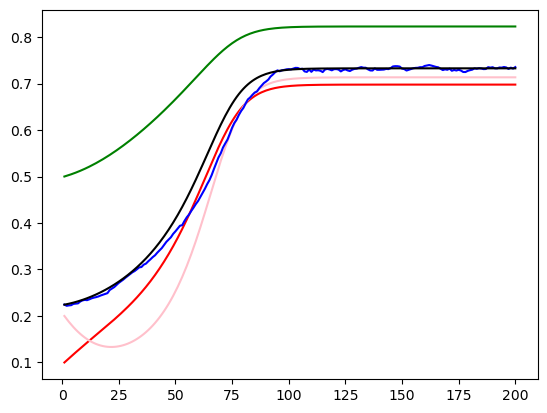

99.99857380000321


In [25]:
start = timer()
f = 5
time =200 # Iterations
n1 = int(500/f)
n2 = int(500/f)

# Rates
w_p,d_p,e_p = 0.05,0.002,0.0004*f
w_r,d_r,e_r = 0.088,0.0015,0.00038*f
w_q,d_q,e_q = 0.08,0.002,0.0004*f

p,q,r = 0.5, 0.2, 0.1

B = block(n1,p,n2,q,r)
block_mat = block_adj(B)
print("block mat done")
T = triadic(block_mat,n1,n2,time, w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)

A = T[0]

mf = mean_field(n1,n2,p,r,q,time,w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)
m = mf[0]
dens = mf[1]

x = np.arange(1,time+1,1)
y = T[1]
plt.plot(x,m[:,0],color = 'green') # p
plt.plot(x,m[:,1],color = 'red') # r
plt.plot(x,m[:,2],color = 'pink') # q
plt.plot(x,y, color = 'blue')
plt.plot(x,dens, color = 'black')
plt.show()
end = timer()
print(end - start)

block mat done
Done!
Done!!
0.0% Complete
1.0% Complete
2.0% Complete
3.0% Complete
4.0% Complete
5.0% Complete
6.0% Complete
7.000000000000001% Complete
8.0% Complete
9.0% Complete
10.0% Complete
11.0% Complete
12.0% Complete
13.0% Complete
14.000000000000002% Complete
15.0% Complete
16.0% Complete
17.0% Complete
18.0% Complete
19.0% Complete
20.0% Complete
21.0% Complete
22.0% Complete
23.0% Complete
24.0% Complete
25.0% Complete
26.0% Complete
27.0% Complete
28.000000000000004% Complete
28.999999999999996% Complete
30.0% Complete
31.0% Complete
32.0% Complete
33.0% Complete
34.0% Complete
35.0% Complete
36.0% Complete
37.0% Complete
38.0% Complete
39.0% Complete
40.0% Complete
41.0% Complete
42.0% Complete
43.0% Complete
44.0% Complete
45.0% Complete
46.0% Complete
47.0% Complete
48.0% Complete
49.0% Complete
50.0% Complete
51.0% Complete
52.0% Complete
53.0% Complete
54.0% Complete
55.00000000000001% Complete
56.00000000000001% Complete
56.99999999999999% Complete
57.99999999999999

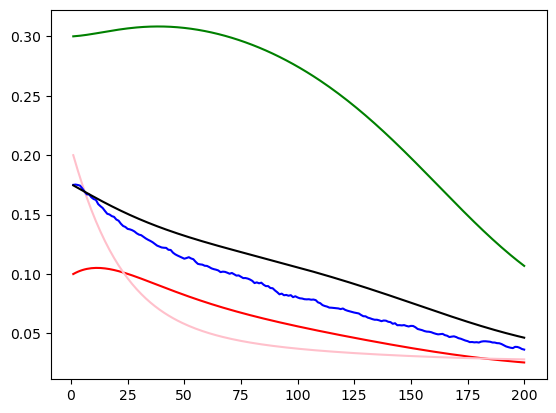

201.2765189999991


In [32]:
start = timer()
f = 5
time =200 # Iterations
n1 = int(500/f)
n2 = int(500/f)

# Rates
w_p,d_p,e_p = 0.05,0.002,0.0004*f
w_r,d_r,e_r = 0.088,0.0015,0.00038*f
w_q,d_q,e_q = 0.08,0.002,0.0004*f

p,q,r = 0.3, 0.2, 0.1

B = block(n1,p,n2,q,r)
block_mat = block_adj(B)
print("block mat done")
T = triadic(block_mat,n1,n2,time, w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)
B = block(n1,p,n2,q,r)
block_mat = block_adj(B)

T2 =triadic(block_mat,n1,n2,time, w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)
A = T[0]
A2 = T2[0]
mf = mean_field(n1,n2,p,r,q,time,w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)
m = mf[0]
dens = mf[1]
clust_mf = mf[2]

x = np.arange(1,time+1,1)
y = T[1]
clust_1 = T[2]
y2 = T2[1]
clust_2 = T2[2]

plt.plot(x,m[:,0],color = 'green') # p
plt.plot(x,m[:,1],color = 'red') # r
plt.plot(x,m[:,2],color = 'pink') # q
plt.plot(x,y, color = 'blue')
plt.plot(x,y2, color = 'grey')
plt.plot(x,dens, color = 'black')
plt.show()

new = [x,m,y,dens,y2, clust_mf, clust_1, clust_2]
end = timer()
print(end - start)

In [50]:
def plot_it(p_in,q_in,r_in):
    f = 5
    time =275 # Iterations
    n1 = int(500/f)
    n2 = int(500/f)

    # Rates
    w_p,d_p,e_p = 0.05,0.002,0.0004*f
    w_r,d_r,e_r = 0.088,0.0015,0.00038*f
    w_q,d_q,e_q = 0.08,0.002,0.0004*f
    
    p,q,r = p_in, q_in, r_in

    B = block(n1,p,n2,q,r)
    block_mat = block_adj(B)
    print("block mat done")

    T = triadic(block_mat,n1,n2,time, w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)
    B = block(n1,p,n2,q,r)
    block_mat = block_adj(B)
    
    T2 =triadic(block_mat,n1,n2,time, w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)
    A = T[0]
    A2 = T2[0]
    mf = mean_field(n1,n2,p,r,q,time,w_p,d_p,e_p, w_r,d_r,e_r, w_q,d_q,e_q)
    m = mf[0]
    dens = mf[1]
    clust_mf = mf[2]

    x = np.arange(1,time+1,1)
    y = T[1]
    clust_1 = T[2]
    y2 = T2[1]
    clust_2 = T2[2]
    
    print("complete")
#    plt.plot(x,m[:,0],color = 'green') # p
 #   plt.plot(x,m[:,1],color = 'red') # r
  #  plt.plot(x,m[:,2],color = 'pink') # q
   # plt.plot(x,y, color = 'blue')
    #plt.plot(x,dens, color = 'black')
    #plt.show()
    return x,m,y,dens,y2, clust_mf , clust_1, clust_2

block mat done
Done!
Done!!
0.0% Complete
4.0% Complete
8.0% Complete
12.0% Complete
16.0% Complete
20.0% Complete
24.0% Complete
28.000000000000004% Complete
32.0% Complete
36.0% Complete
40.0% Complete
44.0% Complete
48.0% Complete
52.0% Complete
56.00000000000001% Complete
60.0% Complete
64.0% Complete
68.0% Complete
72.0% Complete
76.0% Complete
80.0% Complete
84.0% Complete
88.0% Complete
92.0% Complete
96.0% Complete
Done!
Done!!
0.0% Complete
4.0% Complete
8.0% Complete
12.0% Complete
16.0% Complete
20.0% Complete
24.0% Complete
28.000000000000004% Complete
32.0% Complete
36.0% Complete
40.0% Complete
44.0% Complete
48.0% Complete
52.0% Complete
56.00000000000001% Complete
60.0% Complete
64.0% Complete
68.0% Complete
72.0% Complete
76.0% Complete
80.0% Complete
84.0% Complete
88.0% Complete
92.0% Complete
96.0% Complete
complete
block mat done
Done!
Done!!
0.0% Complete
4.0% Complete
8.0% Complete
12.0% Complete
16.0% Complete
20.0% Complete
24.0% Complete
28.000000000000004% Co

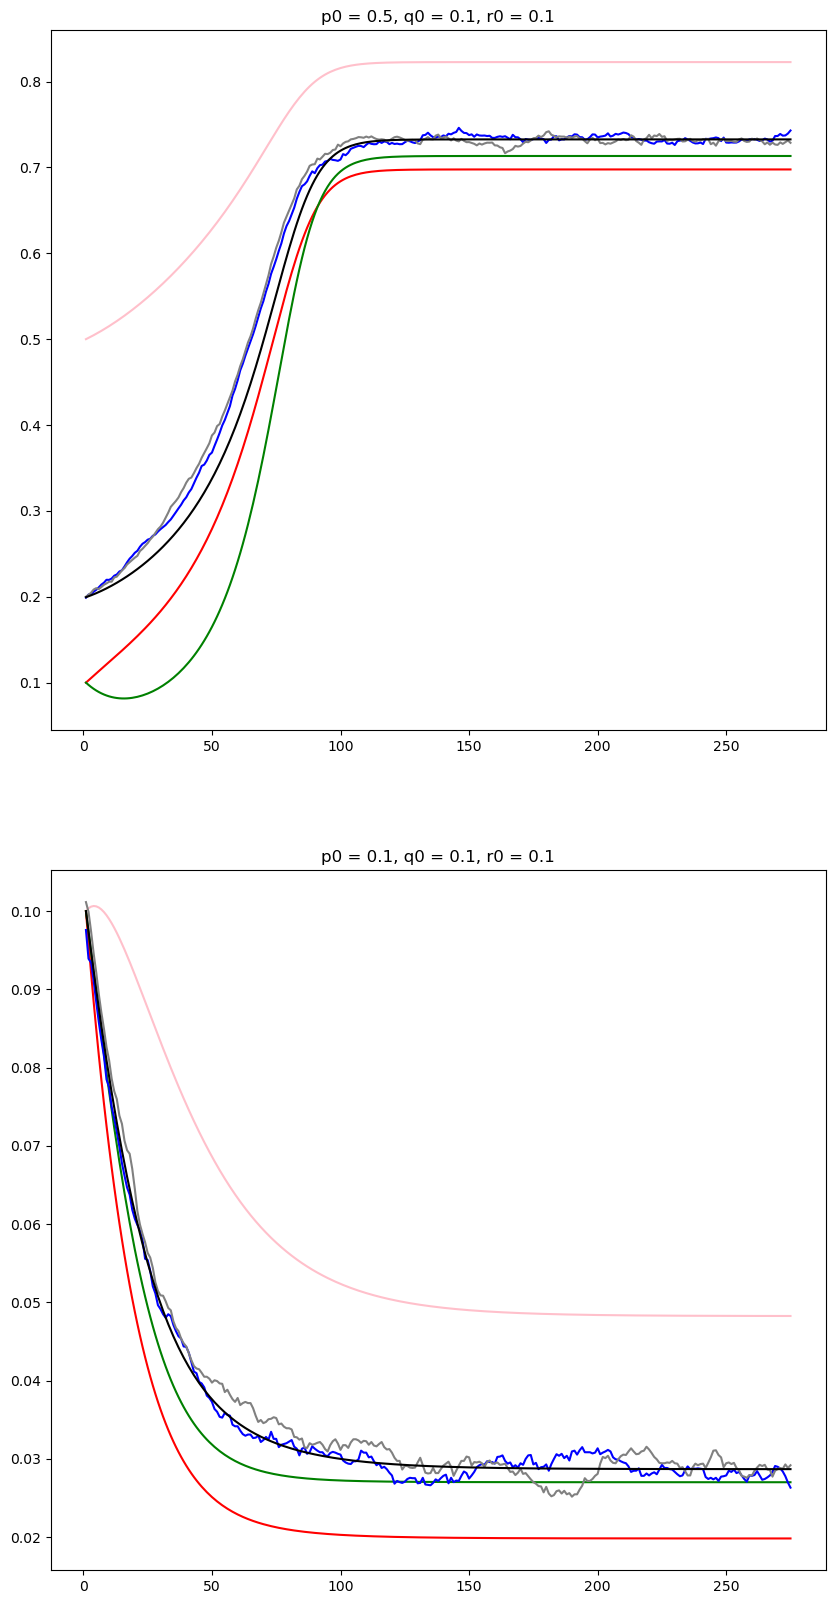

550.8565098000036


In [51]:
def vary_vert():
    p_list = [0.5,0.1]
    q_list = [0.1,0.1]
    r_list = [0.1]
    xi = []
    l = len(p_list)
    rl = len(r_list)
    
    figure, axis = plt.subplots(l*rl,figsize=(10, 10*l*rl))
    
    i = 0
    for elem in range(l):
        p = p_list[elem]
        q = q_list[elem]
        for k in range(rl):
            r = r_list[k]
            output = plot_it(p,q,r)
            x,m,y,dens,y2, clust_mf, clust_1, clust_2 = output[0], output[1], output[2], output[3], output[4], output[5], output[6], output[7]
            xi.append([x,m,y,dens,y2, clust_mf, clust_1, clust_2])
            axis[i].plot(x,m[:,0],color = 'pink')
            axis[i].plot(x,m[:,1],color = 'red')
            axis[i].plot(x,m[:,2],color = 'green')
            axis[i].plot(x,y, color = 'blue')
            axis[i].plot(x,y2, color = 'grey')
            axis[i].plot(x,dens, color = 'black')
            axis[i].set_title("p0 = " + str(p) + ", q0 = " + str(q) + ", r0 = " + str(r))
            i += 1
    plt.show()
    return xi
start = timer()
xi = vary_vert()
end = timer()
print(end-start)

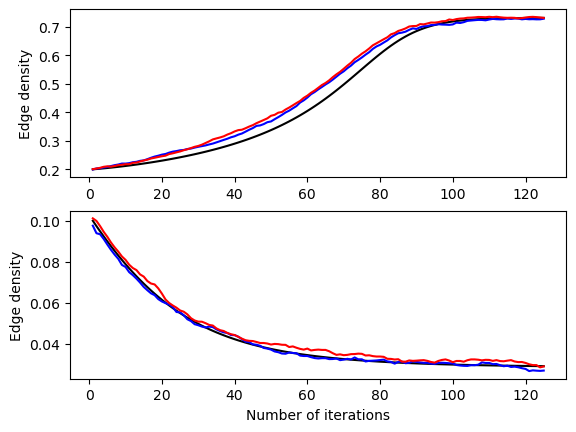

In [62]:
one = xi[0]
two = xi[1]

# xi. = ([x,m,y,dens,y2])
iters = 125
x=one[0][:iters]

figure, axis = plt.subplots(2)

axis[0].plot(x,one[3][:iters], color = 'black')
axis[0].plot(x,one[2][:iters], color = 'blue')
axis[0].plot(x,one[4][:iters], color = 'red')

axis[0].set_ylabel('Edge density')


plt.xlabel("Number of iterations")
plt.ylabel("Edge density")

axis[1].plot(x,two[3][:iters], color = 'black')
axis[1].plot(x,two[2][:iters], color = 'blue')
axis[1].plot(x,two[4][:iters], color = 'red')

plt.xlabel("Number of iterations")
plt.ylabel("Edge density")

plt.show()


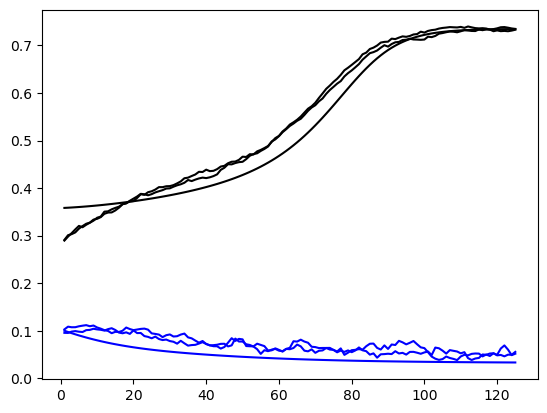

In [58]:
plt.plot(x,one[5][:iters], color = 'black')
plt.plot(x,one[6][:iters], color = 'black')
plt.plot(x,one[7][:iters], color = 'black')

plt.plot(x,two[5][:iters], color = 'blue')
plt.plot(x,two[6][:iters], color = 'blue')
plt.plot(x,two[7][:iters], color = 'blue')
plt.show()

In [57]:
one = xi[0]
two = xi[1]
three = xi[2]
# xi. = ([x,m,y,dens,y2])
iters = 200
x=one[0][:iters]

figure, axis = plt.subplots(3)

axis[0].plot(x,one[3][:iters], color = 'black')
axis[0].plot(x,one[2][:iters], color = 'blue')
axis[0].plot(x,one[4][:iters], color = 'red')

axis[1].plot(x,two[3][:iters], color = 'black')
axis[1].plot(x,two[2][:iters], color = 'blue')
axis[1].plot(x,two[4][:iters], color = 'red')


plt.show()


IndexError: list index out of range

In [ ]:
one = xi[0]
two = xi[1]
three = xi[2]
# xi. = ([x,m,y,dens,y2])
iters = 250
x=one[0][:iters]



plt.plot(x,one[3][:iters], color = 'black')
plt.plot(x,one[2][:iters], color = 'blue')
plt.plot(x,one[4][:iters], color = 'red')

plt.plot(x,two[3][:iters], color = 'black')
plt.plot(x,two[2][:iters], color = 'blue')
plt.plot(x,two[4][:iters], color = 'red')

plt.plot(x,three[3][:iters], color = 'black')
plt.plot(x,three[2][:iters], color = 'blue')
plt.plot(x,three[4][:iters], color = 'red')

plt.xlabel("Number of iterations")
plt.ylabel("Edge density")
plt.show()
two

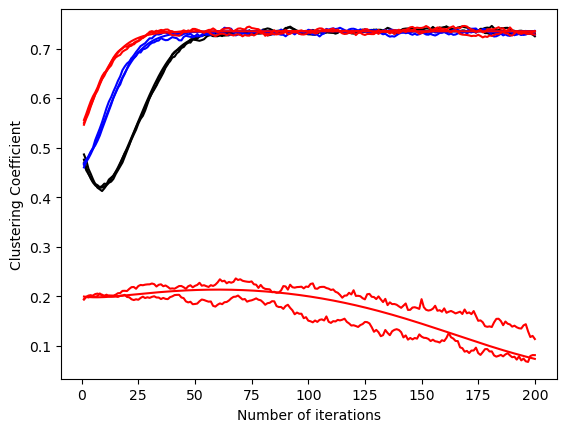

In [33]:
one = xi[0]
two = xi[1]
three = xi[2]
# xi. = ([x,m,y,dens,y2, clust_mf, clust_1, clust_2])
iters = 200
x=one[0][:iters]




plt.plot(x,one[5][:iters], color = 'black')
plt.plot(x,one[6][:iters], color = 'black')
plt.plot(x,one[7][:iters], color = 'black')

plt.plot(x,two[5][:iters], color = 'blue')
plt.plot(x,two[6][:iters], color = 'blue')
plt.plot(x,two[7][:iters], color = 'blue')

plt.plot(x,three[5][:iters], color = 'red')
plt.plot(x,three[6][:iters], color = 'red')
plt.plot(x,three[7][:iters], color = 'red')

plt.plot(x,new[5][:iters], color = 'red')
plt.plot(x,new[6][:iters], color = 'red')
plt.plot(x,new[7][:iters], color = 'red')

plt.xlabel("Number of iterations")
plt.ylabel("Clustering Coefficient")
plt.show()

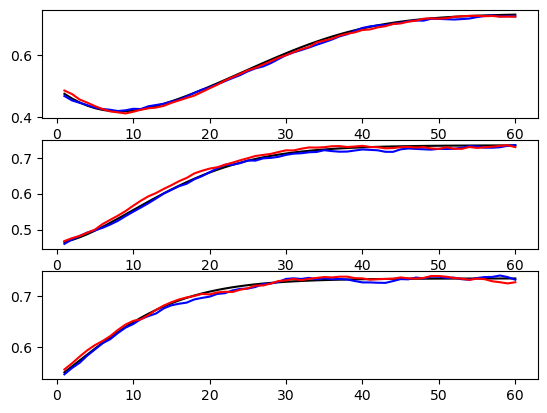

In [31]:
one = xi[0]
two = xi[1]
three = xi[2]
# xi. = ([x,m,y,dens,y2])
iters = 60
x=one[0][:iters]

figure, axis = plt.subplots(3)

axis[0].plot(x,one[5][:iters], color = 'black')
axis[0].plot(x,one[6][:iters], color = 'blue')
axis[0].plot(x,one[7][:iters], color = 'red')

axis[1].plot(x,two[5][:iters], color = 'black')
axis[1].plot(x,two[6][:iters], color = 'blue')
axis[1].plot(x,two[7][:iters], color = 'red')

axis[2].plot(x,three[5][:iters], color = 'black')
axis[2].plot(x,three[6][:iters], color = 'blue')
axis[2].plot(x,three[7][:iters], color = 'red')

plt.show()


In [ ]:
#Sample
y_sample = y
m2_sample = m[:,2]
m0_sample = m[:,0]
dens_sample = dens

In [ ]:
plt.plot(x,y, color = 'blue')
plt.plot(x,dens, color = 'black')
plt.show()

In [ ]:
x = np.arange(1,300+1,1)
#plt.plot(x,m[:,0][:300],color = 'green') # p
#plt.plot(x,m[:,1][:300],color = 'red') # r
#plt.plot(x,m[:,2][:300],color = 'pink') # q
plt.plot(x,y[:300], color = 'blue')
#plt.plot(x,dens[:300], color = 'black')
plt.show()

In [ ]:
#Sample
y_sample2 = y
m2_sample2 = m[:,2]
m0_sample2 = m[:,0]
dens_sample2 = dens

In [ ]:
xi = []
xi.append([x,m,dens])
xi


In [ ]:
xi

In [ ]:
np.arange(1,10,1)